# Graph Pose SLAM

### **Odometry Data:**
From odometry, we typically get the poses $ \textbf{X}_i $ and $ \textbf{X}_j $ in the world frame. These poses represent the robot's estimated positions and orientations based on the odometry readings.

### **Relative Transformation from Poses:**
Using the poses $ \textbf{X}_i $ and $ \textbf{X}_j $ in the world frame, we can compute the **predicted relative pose** of $ \textbf{X}_j $ with respect to $ \textbf{X}_i $, denoted as $ h(\textbf{X}_i, \textbf{X}_j) $. This transformation involves the relative translation and rotation between $ \textbf{X}_i $ and $ \textbf{X}_j $.



${^{i}_{j}X}$: is the pose of the $j_{th}$farme in $i_{th}$ frame, to get the pose of the robot from world coordinate in the $i_{th}$ frame: 

$${^{i}_{j}X}=({^{w}_{i}T ^{-1}} )\times ( {^{w}_{j}X})$$

which is:

 $${^{i}_{j}X}= \begin{bmatrix}
{^{w}_{i}R}^T &   -{^{w}_{i}R}^T \times ({^{w}_{i}P})  \\ 
0 & 1  
\end{bmatrix} \times ( {^{w}_{j}X})$$




Just like what we did to bring point in the world coordinate to camera coordinate, we can do the same here:

$${^{i}_{j}R}=({^{w}_{i}R ^T} )\times ( {^{w}_{j}R})$$



$$^{i}_jP=^{w}_iR^T (  {^{w}_{j}P} -{^{w}_{i}P} )$$

which gives us: 



$$\begin{bmatrix} ^{i}_j x \\  ^{i}_j y \end{bmatrix}=\begin{bmatrix} cos(i^w \theta ) & sin(i^w \theta ) \\ -sin(i^w \theta ) & cos(i^w \theta) \end{bmatrix} \begin{bmatrix} ^{w}_jx - ^{w}_ix \\  ^{w}_jy - ^{w}_iy \end{bmatrix}$$




$$^{i}_j \theta =^{w}_j\theta -{^{w}_{i}\theta}$$

### **Sensor Measurements:**
From the sensor (e.g., a laser scanner or camera), we obtain a measurement $ z_{ij} $, which represents the **observed relative pose** of $ \textbf{X}_j $ with respect to $ \textbf{X}_i $. This measurement typically includes relative position and orientation.




## **Notation** of  $X_i$ and $(x_i, y_i, \theta_i)$


 $(x_i, y_i, \theta_i)$ is a **coordinate representation**,
 $X_i \in SE(2)$ is the **actual pose as a rigid-body transform**,
 and in pose-graph SLAM **nodes live on $SE(2)$**, even if we store them as triples.



**Both are the same pose**, just written in **different representations**.

 $$(x_i, y_i, \theta_i)$$ → **minimal coordinates** (vector in $\mathbb{R}^3$)

 
  $$
  X_i = \begin{bmatrix} R_i & p_i \\ 0 & 1 \end{bmatrix} \in SE(2)
  $$
  → **group (matrix) representation**

They represent **the same physical robot pose in the world frame**.

---

#### What $X_i$ really is (precise statement)

In pose-graph SLAM:

> Each node $X_i$ is an element of the **Lie group** $SE(2)$

$$
X_i \in SE(2)
$$

The matrix form is the **group element**:

$$
X_i = \begin{bmatrix} R(\theta_i) & p_i \\ 0 & 1 \end{bmatrix}
$$

with

$$
p_i = \begin{bmatrix} x_i \\ y_i \end{bmatrix}, \quad R(\theta_i) = \begin{bmatrix} \cos\theta_i & -\sin\theta_i \\ \sin\theta_i & \cos\theta_i \end{bmatrix}
$$

This matrix **acts on points** and composes via matrix multiplication.

---

#### Then what is $(x_i, y_i, \theta_i)$?

That triple is **not a group element** by itself.

It is a **coordinate chart** (a parameterization) of $SE(2)$:

$$
\xi_i = \begin{bmatrix} x_i \\ y_i \\ \theta_i \end{bmatrix} \in \mathbb{R}^3
$$

You use it because:

* it is minimal (3 numbers),
* it is convenient for storage and optimization,
* Jacobians are easier to write.

But:

❌ You cannot compose poses by adding these vectors  
❌ You cannot invert poses by negating them

Those operations belong to the group $SE(2)$, not $\mathbb{R}^3$.

---

#### Relationship between the two

There is a **mapping** from coordinates to group element:

$$
X_i = \mathrm{Exp}(\xi_i)
$$

In practice (for 2D SLAM), this is usually implemented directly as:

$$
(x_i, y_i, \theta_i) \;\longrightarrow\; \begin{bmatrix} R(\theta_i) & p_i \\ 0 & 1 \end{bmatrix}
$$

Strictly speaking, the true Lie-theoretic exponential uses twists, but most 2D SLAM code uses this "direct" embedding because it is exact in $SE(2)$.

---

#### Why SLAM papers mix the notation

You will often see:

* "Let $X_i = (x_i, y_i, \theta_i)$"
* and later
* "The relative pose is $X_i^{-1} X_j$"

This is **abuse of notation**.

What they mean is:

* **state variables** are stored as $(x,y,\theta)$
* **operations** are done in $SE(2)$

Libraries like **g2o, Ceres, GTSAM** all do this internally.

---

#### How this shows up in optimization

During optimization you typically have:

* state vector (minimal):
  $$
  \delta x_i = (\delta x, \delta y, \delta \theta)
  $$

* update rule:
  $$
  X_i \leftarrow X_i \oplus \delta x_i
  $$

where $\oplus$ means:

$$
X_i \leftarrow X_i \cdot \mathrm{Exp}(\delta x_i)
$$

This is why we **don't add angles directly** during optimization.

---



### **State Vector**
The state vector $ \mathbb{X} $ contains the 2D poses of all $ n $ nodes:

$
\mathbb{X} = (x_1, y_1, \theta_1, x_2, y_2, \theta_2, \dots, x_n, y_n, \theta_n)
$

Each pose $ \textbf{X}_i = (x_i, y_i, \theta_i) $ represents the position and orientation of a node.

---




### **Error Function:**

The error function compares the **predicted relative pose** $ h(\textbf{X}_i, \textbf{X}_j) $ (computed from odometry poses) to the **observed relative pose** $ z_{ij} $ (sensor measurement):

$e_{ij} = z_{ij} - h(\textbf{X}_i, \textbf{X}_j)$


$
\textbf{e}_{ij}(\mathbb{X}) = \textbf{e}_{ij}(\textbf{X}_i, \textbf{X}_j)
$

Where the components of $ \textbf{e}_{ij} $ are given by:

$\mathbf{e}_{ij}(\mathbf{X}_i, \mathbf{X}_j) =
\begin{pmatrix}
^i_jx \\
^i_jy \\
^{i}_j \theta
\end{pmatrix}
=$
$
\begin{bmatrix}
\cos(\theta_i)(x_j - x_i) + \sin(\theta_i)(y_j - y_i) - z_x \\
-\sin(\theta_i)(x_j - x_i) + \cos(\theta_i)(y_j - y_i) - z_y \\
\theta_j - \theta_i - z_\theta
\end{bmatrix}$

Here:
- $ z_x, z_y, z_\theta $ are the observed relative pose measurements.
- $ x_j, y_j, \theta_j $ and $ x_i, y_i, \theta_i $ are the current estimates of the poses.

---


## **Numerical Example**


#### 1) Nodes (unknowns to estimate)

Let the graph have 4 poses in the **world frame**:

$$
X_i = (x_i, y_i, \theta_i), \quad i \in \{0,1,2,3\}
$$

We fix the gauge by anchoring:

$$
X_0 = (0,\ 0,\ 0)
$$

---

#### 2) Odometry edges (inputs): 0→1→2→3

Odometry provides relative pose increments in the **local frame of the starting node** of each edge:

$$
u_{01} = (\Delta x,\Delta y,\Delta\theta) = (1.10,\ 0.00,\ 0.05)
$$

$$
u_{12} = (1.00,\ 0.00,\ 0.02)
$$

$$
u_{23} = (0.00,\ 1.10,\ 1.70)
$$

These are "controls" / odometry constraints. In pose-graph form, they are measurements on edges, but we conceptually separate them as **odometry**.

#### Odometry motion model (how it predicts the next pose)

From $X_i$ and odometry $u_{i,i+1}$, predict $X_{i+1}$:

$$
p_{i+1} = p_i + R(\theta_i)\begin{bmatrix}\Delta x \\ \Delta y\end{bmatrix}
$$

$$
\theta_{i+1} = \theta_i + \Delta\theta
$$

where $p_i = \begin{bmatrix}x_i \\ y_i\end{bmatrix}$ and

$$
R(\theta_i)= \begin{bmatrix} \cos\theta_i & -\sin\theta_i \\ \sin\theta_i & \cos\theta_i \end{bmatrix}
$$

---

#### 3) Integrate odometry to get an initial world-frame guess

Start:

$$
X_0 = (0,\ 0,\ 0)
$$

#### Compute $X_1$

$$
p_1 = p_0 + R(0)\begin{bmatrix}1.10\\0\end{bmatrix} = \begin{bmatrix}1.10\\0\end{bmatrix}, \quad \theta_1 = 0 + 0.05 = 0.05
$$

$$
X_1 = (1.10,\ 0.00,\ 0.05)
$$

#### Compute $X_2$

$$
p_2 = p_1 + R(0.05)\begin{bmatrix}1.00\\0\end{bmatrix}
$$

Since $R(\theta)\begin{bmatrix}1\\0\end{bmatrix} = \begin{bmatrix}\cos\theta \\ \sin\theta\end{bmatrix}$,

$$
p_2 \approx \begin{bmatrix}1.10\\0\end{bmatrix} + \begin{bmatrix}\cos 0.05 \\ \sin 0.05\end{bmatrix} = \begin{bmatrix}1.10 + 0.998750 \\ 0 + 0.049979\end{bmatrix} = \begin{bmatrix}2.098750 \\ 0.049979\end{bmatrix}
$$

$$
\theta_2 = 0.05 + 0.02 = 0.07
$$

$$
X_2 \approx (2.098750,\ 0.049979,\ 0.07)
$$

#### Compute $X_3$

$$
p_3 = p_2 + R(0.07)\begin{bmatrix}0\\1.10\end{bmatrix}
$$

And $R(\theta)\begin{bmatrix}0\\1\end{bmatrix}=\begin{bmatrix}-\sin\theta \\ \cos\theta\end{bmatrix}$, so

$$
R(0.07)\begin{bmatrix}0\\1.10\end{bmatrix} = 1.10\begin{bmatrix}-\sin 0.07 \\ \cos 0.07\end{bmatrix} \approx \begin{bmatrix}-0.076937 \\ 1.097306\end{bmatrix}
$$

$$
p_3 \approx \begin{bmatrix}2.098750 \\ 0.049979\end{bmatrix} + \begin{bmatrix}-0.076937 \\ 1.097306\end{bmatrix} = \begin{bmatrix}2.021813 \\ 1.147285\end{bmatrix}
$$

$$
\theta_3 = 0.07 + 1.70 = 1.77
$$

$$
X_3 \approx (2.021813,\ 1.147285,\ 1.77)
$$

So the odometry chain gives the **initial guess**:

* $X_0 = (0.000000,\ 0.000000,\ 0.00)$
* $X_1 = (1.100000,\ 0.000000,\ 0.05)$
* $X_2 \approx (2.098750,\ 0.049979,\ 0.07)$
* $X_3 \approx (2.021813,\ 1.147285,\ 1.77)$

---

#### 4) Loop-closure measurement edge (sensor): 3→0

Now add a **sensor-derived loop closure** (scan matching / vision) that directly measures the relative pose of node 0 expressed in node 3:

$$
z_{30} = (\Delta x,\Delta y,\Delta\theta) = (-1.00,\ 2.00,\ -\pi/2)
$$

This is **not odometry**; it's a **measurement constraint** between non-consecutive poses.

---

#### 5) What pose-graph SLAM optimizes

The unknowns are $X_1, X_2, X_3$. The graph enforces:

* odometry constraints:
  $$
  X_0^{-1}X_1 \approx u_{01},\quad X_1^{-1}X_2 \approx u_{12},\quad X_2^{-1}X_3 \approx u_{23}
  $$

* loop-closure constraint:
  $$
  X_3^{-1}X_0 \approx z_{30}
  $$


#### 6) Compute the predicted loop closure $\hat z_{30} = X_3^{-1} X_0$

From the odometry-integrated initial guess we had:

$$
X_0 = (x_0,y_0,\theta_0) = (0,\ 0,\ 0)
$$

$$
X_3 \approx (x_3,y_3,\theta_3) = (2.021813,\ 1.147285,\ 1.77)
$$

Let $p_i = \begin{bmatrix}x_i\\y_i\end{bmatrix}$. The predicted relative pose (pose of 0 expressed in frame 3) is:

$$
\hat p_{30} = R(\theta_3)^T (p_0 - p_3), \quad \hat\theta_{30} = \mathrm{wrap}(\theta_0 - \theta_3)
$$

Compute $p_0 - p_3$:

$$
p_0 - p_3 = \begin{bmatrix} 0 - 2.021813 \\ 0 - 1.147285 \end{bmatrix} = \begin{bmatrix} -2.021813 \\ -1.147285 \end{bmatrix}
$$

And

$$
R(\theta_3)^T = \begin{bmatrix} \cos\theta_3 & \sin\theta_3 \\ -\sin\theta_3 & \cos\theta_3 \end{bmatrix}
$$

Using $\theta_3 = 1.77$ rad, $\cos 1.77 \approx -0.198669$, $\sin 1.77 \approx 0.980067$:

$$
\hat p_{30} = \begin{bmatrix} -0.198669 & 0.980067 \\ -0.980067 & -0.198669 \end{bmatrix} \begin{bmatrix} -2.021813\\ -1.147285 \end{bmatrix} \approx \begin{bmatrix} -0.724503\\ 2.208866 \end{bmatrix}
$$

Yaw:

$$
\hat\theta_{30} = \mathrm{wrap}(0 - 1.77) = -1.77
$$

So the **predicted** loop closure from the current pose estimates is:

$$
\hat z_{30} = (\hat{\Delta x},\hat{\Delta y},\hat{\Delta\theta}) \approx (-0.724503,\ 2.208866,\ -1.77)
$$

---

#### 7) Compare with the measured loop closure $z_{30}$ and compute the error

Given the loop-closure measurement (sensor):

$$
z_{30} = (\Delta x,\Delta y,\Delta\theta) = (-1.00,\ 2.00,\ -\pi/2)
$$

A very common (simple) residual is:

$$
e_{30} = \begin{bmatrix} e_x \\ e_y \\ e_\theta \end{bmatrix} = \begin{bmatrix} \hat{\Delta x} - \Delta x \\ \hat{\Delta y} - \Delta y \\ \mathrm{wrap}(\hat{\Delta\theta} - \Delta\theta) \end{bmatrix}
$$

Compute translation residual:

$$
e_x = -0.724503 - (-1.00) = 0.275497
$$

$$
e_y = 2.208866 - 2.00 = 0.208866
$$

Compute angle residual:

$$
e_\theta = \mathrm{wrap}\left(-1.77 - \left(-\frac{\pi}{2}\right)\right) = \mathrm{wrap}\left(-1.77 + 1.570796\right) = \mathrm{wrap}(-0.199204) = -0.199204
$$

So the loop-closure residual is:

$$
e_{30} \approx \begin{bmatrix} 0.275497 \\ 0.208866 \\ -0.199204 \end{bmatrix}
$$

Interpretation in plain words: in the coordinate frame of node 3, your current trajectory predicts node 0 to be about **0.276 m** off in local-x, **0.209 m** off in local-y, and **0.199 rad** (≈ 11.4°) off in heading compared to what the sensor says.

---

## **The information matrix $\Omega$:**

### What it is

For each edge (measurement) you assume measurement noise with covariance:

$$
\Sigma_{ij} \in \mathbb{R}^{3\times 3}
$$

Then the **information matrix** is its inverse:

$$
\Omega_{ij} = \Sigma_{ij}^{-1}
$$

* Large covariance (uncertain measurement) ⟶ small information (weak weight)
* Small covariance (confident measurement) ⟶ large information (strong weight)

#### Why we need it

Not all constraints are equally reliable:

* Odometry often drifts (esp. wheel slip): higher uncertainty over time
* Loop closures can be very accurate, or sometimes wrong/outliers

$\Omega$ is how you tell the optimizer how much to "trust" each constraint.

---

#### How it appears in the pose-graph cost function

Pose graph SLAM is usually written as a weighted least squares problem:

$$
\min_{\{X_i\}} \sum_{(i,j)\in \mathcal{E}} e_{ij}^T \Omega_{ij} e_{ij}
$$

For our loop closure edge (3,0):

$$
\text{cost}_{30} = e_{30}^T \Omega_{30} e_{30}
$$

This is the **Mahalanobis distance**: it penalizes errors more strongly along directions you are confident about.

---

####  Choosing $\Sigma$ / $\Omega$ in practice (simple, common cases)

#### Case A: independent noise in $(x,y,\theta)$

Often you assume:

$$
\Sigma = \mathrm{diag}(\sigma_x^2,\ \sigma_y^2,\ \sigma_\theta^2) \quad\Rightarrow\quad \Omega = \mathrm{diag}\left(\frac{1}{\sigma_x^2},\ \frac{1}{\sigma_y^2},\ \frac{1}{\sigma_\theta^2}\right)
$$

Example (numbers just to illustrate):

* loop closure believed accurate: $\sigma_x=\sigma_y=0.10$ m, $\sigma_\theta=0.05$ rad

$$
\Omega_{LC} = \mathrm{diag}(100,\ 100,\ 400)
$$

Then angular errors get penalized more than translation errors in this example (because $1/0.05^2 = 400$).

#### Case B: correlated noise

If $(x,y,\theta)$ are correlated (common with scan matching), $\Sigma$ has off-diagonal terms, and $\Omega=\Sigma^{-1}$ is full. This rotates/scales the penalty ellipse in error space.

---

####  Where $\Omega$ gets used computationally

When you linearize each residual:

$$
e_{ij}(X) \approx e_{ij}(X^{(k)}) + J_{ij}\delta
$$

the normal equations accumulate weights:

$$
H = \sum J_{ij}^T \Omega_{ij} J_{ij}, \quad b = \sum J_{ij}^T \Omega_{ij} e_{ij}
$$

So $\Omega$ directly controls how much each edge contributes to the Hessian $H$ and gradient $b$.

---

####  One important warning: loop-closure outliers

If a loop closure is wrong, a large $\Omega$ can break the solution. In real systems you often use:

* a **robust kernel** (Huber/Cauchy) multiplying the cost, and/or
* loop-closure verification (RANSAC, consistency checks)

---

## **Wrap function is**

The **wrap** (or **angle normalization**) function maps any real angle to a **principal interval**, usually:

$$
(-\pi,\ \pi]
$$

A standard definition is:

$$
\mathrm{wrap}(\alpha) = (\alpha + \pi)\ \bmod\ (2\pi)\ - \pi
$$

This works for **any real number** $\alpha \in \mathbb{R}$.

Example values:

* $\mathrm{wrap}(3.5) \approx -2.783$
* $\mathrm{wrap}(-3.5) \approx 2.783$
* $\mathrm{wrap}(2\pi + 0.1) = 0.1$
* $\mathrm{wrap}(-4\pi - 0.2) = -0.2$

---

#### Why angles are special (topology issue)

Angles **do not live in $\mathbb{R}$**.

They live on a **circle** $S^1$:

$$
\theta \equiv \theta + 2\pi k \quad \forall k \in \mathbb{Z}
$$

This means:

* $\theta = -\pi$ and $\theta = \pi$ represent the **same orientation**
* There is **no global linear ordering**

But subtraction assumes a linear space.

---

#### What goes wrong without wrapping

Suppose the true relative orientation error is tiny:

* predicted: $\hat\theta = +179^\circ$
* measured: $\theta = -179^\circ$

Naive subtraction:

$$
\hat\theta - \theta = 179^\circ - (-179^\circ) = 358^\circ
$$

But geometrically, the orientations differ by only:

$$
2^\circ
$$

This is a **catastrophic error** if you feed it to an optimizer.

Applying wrap:

$$
\mathrm{wrap}(358^\circ) = -2^\circ
$$

Now the residual reflects the **true smallest rotation**.

---

#### What wrap really computes (geometric meaning)

The wrap function computes the **shortest angular difference** on the circle:

$$
\mathrm{wrap}(\theta_1 - \theta_2) = \operatorname*{argmin}_{\delta \in (-\pi,\pi]} \left| \delta \right| \quad \text{s.t. } \theta_1 = \theta_2 + \delta \ (\text{mod } 2\pi)
$$

In words:

> "What is the smallest rotation that aligns one orientation with the other?"

---

#### Why SLAM must use wrap in residuals

In pose-graph SLAM, the angular residual is always:

$$
e_\theta = \mathrm{wrap}(\hat\theta_{ij} - \theta_{ij}^{meas})
$$

If you don't wrap:

* residuals jump discontinuously at $\pm \pi$
* the cost function becomes **non-smooth**
* Gauss-Newton / LM can diverge or oscillate
* Hessian and Jacobians become meaningless near $\pm \pi$

Wrap restores **local smoothness**, which is essential for linearization-based solvers.

---

#### Relation to Lie groups (important intuition)

On $SO(2)$:

* orientation error is not subtraction
* it is **group difference**

$$
R_{\text{err}} = R(\hat\theta)^T R(\theta)
$$

The angle of $R_{\text{err}}$ is **automatically wrapped** into $(-\pi,\pi]$.

Using wrap is a **cheap coordinate-level substitute** for doing the full group computation.

---

#### Why wrap is NOT needed for translation

* $x, y \in \mathbb{R}$ → linear space
* subtraction is well-defined globally
* no periodicity

Only angles have this issue.

---

#### Typical wrap implementations

Mathematically correct and copy-paste safe:

$$
\mathrm{wrap}(\alpha) = (\alpha + \pi) \bmod (2\pi) - \pi
$$

Alternative equivalent form:

$$
\mathrm{wrap}(\alpha) = \operatorname{atan2}(\sin\alpha,\ \cos\alpha)
$$

Both map to $(-\pi,\pi]$.

---

#### When wrap is *not* enough (advanced note)

If angular error exceeds $\pi$:

* linearization is invalid
* optimizer may converge to the wrong local minimum

That's why:

* good initialization matters
* loop-closure verification is critical
* some systems re-linearize on manifolds explicitly (SE(2), SE(3))

---

#### One-sentence takeaway

> **Wrap is needed because angles live on a circle, not a line — it ensures the angular residual represents the shortest physical rotation and keeps SLAM optimization smooth and correct.**



#### The log map for $SO(2)$

For a 2D rotation matrix:

$$
R(\theta) = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}
$$

The **log map** is:

$$
\log: SO(2) \to \mathbb{R}
$$

Given a rotation matrix $R$, we recover its angle $\theta$:

$$
\theta = \atan2(R_{21}, R_{11})
$$

where $R_{21} = \sin\theta$, $R_{11} = \cos\theta$.

The key: the $\atan2$ function returns values in $(-\pi,\pi]$, so $\log(R)$ is **automatically wrapped**.

---

####  Composition and error on $SO(2)$

True relative pose computation without coordinates:

Let $R_i, R_j \in SO(2)$ be the rotation matrices.

The **predicted relative rotation** from $i$ to $j$ is:

$$
\hat{R}_{ij} = R_i^T R_j
$$

The **measured relative rotation** is $R_{ij}^{\text{meas}} = R(\theta_{ij}^{\text{meas}})$.

The **error rotation** is:

$$
R_{\text{err}} = (R_{ij}^{\text{meas}})^T \hat{R}_{ij}
$$

The angular error is:

$$
e_\theta = \log(R_{\text{err}})
$$

This is **mathematically equivalent** to:

$$
e_\theta = \mathrm{wrap}(\hat\theta_{ij} - \theta_{ij}^{\text{meas}})
$$

---

####  Proof of equivalence

Let's prove the equivalence:

1. $\hat\theta_{ij} = \theta_j - \theta_i$ (mod $2\pi$)
2. Compute $R_{\text{err}} = R(-\theta_{ij}^{\text{meas}}) R(\theta_j - \theta_i) = R(\theta_j - \theta_i - \theta_{ij}^{\text{meas}})$
3. $\log(R_{\text{err}}) = \theta_j - \theta_i - \theta_{ij}^{\text{meas}}$ (wrapped to $(-\pi,\pi]$)
4. This equals $\mathrm{wrap}(\hat\theta_{ij} - \theta_{ij}^{\text{meas}})$

✅ The wrap function is essentially the log map in coordinate form.

---

####  Extension to $SE(2)$

For full 2D poses $(x, y, \theta) \in SE(2)$, the error is:

$$
e_{ij} = \log\left( T_{ij}^{\text{meas}, -1} \cdot T_i^{-1} T_j \right)
$$

where $T_i = \begin{bmatrix} R(\theta_i) & p_i \\ 0 & 1 \end{bmatrix} \in SE(2)$.

The log map for $SE(2)$ returns a 3D vector:

$$
\log: SE(2) \to \mathbb{R}^3
$$

First two components: translation in the body frame  
Third component: rotation angle (wrapped)

---

####  What happens in $SE(3)$

In 3D, rotations are in $SO(3)$. The log map is more involved:

For $R \in SO(3)$, the angle-axis representation:

$$
\log(R) = \frac{\phi}{2\sin\phi}(R - R^T)^\vee
$$

where $\phi = \arccos\left(\frac{\operatorname{tr}(R) - 1}{2}\right)$.

The result is a 3D vector $\omega \in \mathbb{R}^3$ with $|\omega| \leq \pi$.

This automatically **wraps** large rotations to the shortest geodesic.

---

####  Why this matters for optimization

When we linearize the cost function:

$$
e_{ij}(X + \delta) \approx e_{ij}(X) + J_{ij}\delta
$$

The Jacobian $J_{ij}$ relates **state perturbations** $\delta \in \mathbb{R}^3$ to **error changes**.

If we use naive angle subtraction without wrap, the Jacobian is wrong when errors are near $\pm\pi$:

**With wrap** (log map):
$$
\frac{\partial e_\theta}{\partial \theta_i} = -1
$$

**Without wrap** (at discontinuity):
$$
\frac{\partial e_\theta}{\partial \theta_i} \text{ can be } \pm 2\pi
$$

This wrong Jacobian breaks Gauss-Newton convergence.

---

####  Implementation in practice

In C++ libraries like g2o, Ceres, GTSAM:

```cpp
// The "right" way using SE(2) operations
SE2 Ti(pose_i), Tj(pose_j), Tij_meas(measurement);
SE2 error = Tij_meas.inverse() * Ti.inverse() * Tj;
Vector3 e = error.log();  // Automatically wrapped

// Equivalent to:
Vector3 e;
e.head<2>() = R_i.transpose() * (p_j - p_i) - t_ij_meas;
e(2) = wrap(theta_j - theta_i - theta_ij_meas);
```

---

####  One-liner intuition

> **wrap = log map in coordinate form**

The wrap function isn't a hack — it's the coordinate representation of the mathematically correct **logarithmic map** from the Lie group to its tangent space.

---

####  Takeaway for SLAM implementation

1. **Always use wrap for angle residuals**
2. It's equivalent to using the log map
3. It ensures smooth, correct optimization
4. For 3D, use proper $SO(3)$/quaternion operations
5. Libraries handle this internally; understand why

---


### **Linearization of the Error Function**

$$
X_i = (x_i,y_i,\theta_i),\quad X_j=(x_j,y_j,\theta_j)
$$

and define small increments

$$
\delta x = \begin{bmatrix}\delta x_i\\ \delta y_i\\ \delta \theta_i\\ \delta x_j\\ \delta y_j\\ \delta \theta_j\end{bmatrix}
$$

####  Residual definition

$$
e_{ij} = z_{ij} - h(X_i,X_j)
$$

(Usually the angle component is wrapped, but I'll keep your form and mention wrap at the end.)

Let

$$
\Delta x = x_j - x_i,\quad \Delta y = y_j - y_i,\quad c=\cos\theta_i,\quad s=\sin\theta_i
$$

Then your prediction is:

$$
h(X_i,X_j)= \begin{bmatrix} c\Delta x + s\Delta y \\ -s\Delta x + c\Delta y \\ \theta_j-\theta_i \end{bmatrix}
$$

#### First-order Taylor linearization

Taylor expand $h$ around the current estimate $\bar X_i,\bar X_j$:

$$
h(X_i+\delta X_i, X_j+\delta X_j)\approx h(\bar X_i,\bar X_j) + J_{ij}\delta x
$$

So the residual becomes:

$$
e_{ij}(\delta x) = z_{ij} - h(\bar X_i+\delta X_i,\bar X_j+\delta X_j) \approx \underbrace{\left(z_{ij}-h(\bar X_i,\bar X_j)\right)}_{\bar e_{ij}} - J_{ij}\delta x
$$

This is the standard linear form:

$$
e_{ij}(\delta x) \approx \bar e_{ij} - J_{ij}\delta x
$$

where $J_{ij} = \frac{\partial h}{\partial [X_i,X_j]}$ evaluated at the current estimate.

---

####  Compute the Jacobians $J_i$ and $J_j$

Write $J_{ij} = [J_i\ J_j]$ with each $3\times 3$.

#### **Derivatives of $h_1 = c\Delta x + s\Delta y$**

* w.r.t $x_i,y_i$: because $\Delta x = x_j-x_i$, $\Delta y=y_j-y_i$

$$
\frac{\partial h_1}{\partial x_i} = -c,\quad \frac{\partial h_1}{\partial y_i} = -s
$$

* w.r.t $\theta_i$: $\frac{d}{d\theta_i}c=-s$, $\frac{d}{d\theta_i}s=c$

$$
\frac{\partial h_1}{\partial \theta_i} = (-s)\Delta x + (c)\Delta y
$$

* w.r.t $x_j,y_j,\theta_j$

$$
\frac{\partial h_1}{\partial x_j}=c,\quad \frac{\partial h_1}{\partial y_j}=s,\quad \frac{\partial h_1}{\partial \theta_j}=0
$$

#### **Derivatives of $h_2 = -s\Delta x + c\Delta y$**

* w.r.t $x_i,y_i$

$$
\frac{\partial h_2}{\partial x_i} = s,\quad \frac{\partial h_2}{\partial y_i} = -c
$$

* w.r.t $\theta_i$: $\frac{d}{d\theta_i}(-s)=-c$, $\frac{d}{d\theta_i}c=-s$

$$
\frac{\partial h_2}{\partial \theta_i} = (-c)\Delta x + (-s)\Delta y = -(c\Delta x + s\Delta y)
$$

* w.r.t $x_j,y_j,\theta_j$

$$
\frac{\partial h_2}{\partial x_j}=-s,\quad \frac{\partial h_2}{\partial y_j}=c,\quad \frac{\partial h_2}{\partial \theta_j}=0
$$

#### **Derivatives of $h_3 = \theta_j - \theta_i$**

$$
\frac{\partial h_3}{\partial x_i}=0,\quad \frac{\partial h_3}{\partial y_i}=0,\quad \frac{\partial h_3}{\partial \theta_i}=-1
$$

$$
\frac{\partial h_3}{\partial x_j}=0,\quad \frac{\partial h_3}{\partial y_j}=0,\quad \frac{\partial h_3}{\partial \theta_j}=1
$$

---

#### **Final Jacobians**

$$
J_i = \begin{bmatrix}
-c & -s & -s\Delta x + c\Delta y \\
s & -c & -c\Delta x - s\Delta y \\
0 &  0 & -1
\end{bmatrix}
$$

$$
J_j = \begin{bmatrix}
c &  s & 0 \\
-s &  c & 0 \\
0 &  0 & 1
\end{bmatrix}
$$

And the full Jacobian:

$$
J_{ij} = \begin{bmatrix} J_i & J_j \end{bmatrix}
$$

---

#### Linearized residual form used in Gauss-Newton / LM

Evaluate at the current estimate $(\bar X_i,\bar X_j)$:

$$
\bar e_{ij} = z_{ij} - h(\bar X_i,\bar X_j)
$$

Then:

$$
e_{ij}(\delta x) \approx \bar e_{ij} - J_{ij}\delta x
$$

This is what you plug into the weighted least squares:

$$
\min_{\delta x}\ \left\| \bar e_{ij} - J_{ij}\delta x \right\|_{\Omega_{ij}}^2 = (\bar e_{ij} - J_{ij}\delta x)^T \Omega_{ij} (\bar e_{ij} - J_{ij}\delta x)
$$

---

#### Note about wrapping the angle residual

In practice you do:

$$
e_\theta = \mathrm{wrap}\left(z_\theta - (\theta_j-\theta_i)\right)
$$

For small residuals (which is where linearization is valid), $\mathrm{wrap}(\cdot)$ behaves like identity, so the Jacobians above remain the same locally.

## **Quadratic approximation of the cost**
Starting point (single edge $(i,j)$):

$$
\min_{\delta x}\ \left\| \bar e_{ij} - J_{ij}\delta x \right\|_{\Omega_{ij}}^2 \;=\; \min_{\delta x}\ (\bar e_{ij} - J_{ij}\delta x)^T \Omega_{ij} (\bar e_{ij} - J_{ij}\delta x)
$$

It's convenient to include the $\frac{1}{2}$ (it doesn't change the minimizer):

$$
\min_{\delta x}\ E(\delta x),\quad E(\delta x)=\frac{1}{2}(\bar e_{ij} - J_{ij}\delta x)^T \Omega_{ij} (\bar e_{ij} - J_{ij}\delta x)
$$

---



Expand the product:

$$
E(\delta x) = \frac{1}{2}\left( \bar e_{ij}^T\Omega_{ij}\bar e_{ij} - 2\,\delta x^T J_{ij}^T\Omega_{ij}\bar e_{ij} + \delta x^T J_{ij}^T\Omega_{ij}J_{ij}\delta x \right)
$$

The first term $\frac{1}{2}\bar e_{ij}^T\Omega_{ij}\bar e_{ij}$ is constant w.r.t. $\delta x$.

---

## **Take derivative w.r.t. $\delta x$**

Use the standard identities (with $A$ symmetric):

* $\frac{\partial}{\partial x}(x^T A x) = (A + A^T)x = 2Ax$
* $\frac{\partial}{\partial x}(x^T c) = c$

Here $J_{ij}^T\Omega_{ij}J_{ij}$ is symmetric if $\Omega_{ij}$ is symmetric (it is).

So:

$$
\frac{\partial E}{\partial \delta x} = - J_{ij}^T\Omega_{ij}\bar e_{ij} + J_{ij}^T\Omega_{ij}J_{ij}\,\delta x
$$

---

## **Set derivative to zero (normal equations)**

$$
- J_{ij}^T\Omega_{ij}\bar e_{ij} + J_{ij}^T\Omega_{ij}J_{ij}\,\delta x = 0
$$

Rearrange:

$$
\left(J_{ij}^T\Omega_{ij}J_{ij}\right)\delta x = J_{ij}^T\Omega_{ij}\bar e_{ij}
$$

Define:

$$
H_{ij} = J_{ij}^T\Omega_{ij}J_{ij}, \quad b_{ij} = J_{ij}^T\Omega_{ij}\bar e_{ij}
$$

Then:

$$
H_{ij}\,\delta x = b_{ij}
$$

---

## **Optional: relate $J_{ij}$ to $J_i, J_j$**

If

$$
\delta x = \begin{bmatrix} \Delta x_i \\ \Delta x_j \end{bmatrix}, \quad J_{ij} = \begin{bmatrix} J_i & J_j \end{bmatrix}
$$

then the blocks are:

$$
H_{ii}=J_i^T\Omega J_i,\quad H_{ij}=J_i^T\Omega J_j,\quad H_{ji}=J_j^T\Omega J_i,\quad H_{jj}=J_j^T\Omega J_j
$$

$$
b_i = J_i^T\Omega \bar e,\quad b_j = J_j^T\Omega \bar e
$$

That's the exact per-edge contribution you accumulate into the global sparse system $H\Delta x=b$.

For this error, function, which is a function of 6 variables, $(x_i,y_i,\theta_i,x_j,y_j,\theta_j)$, the $J_{ij}$ element of the jacobian matrix is:

$\\ J_{ij}=\begin{bmatrix} 0 & ... & 0 & \frac{\partial ^{i}_jx}{ \partial _{i} x}      &  \frac{\partial ^{i}_jx}{ \partial _{i} y}  & \frac{\partial ^{i}_j x}{ \partial _{i} \theta} &0 &... & \frac{\partial ^{i}_jx}{ \partial _{j} x}      &  \frac{\partial ^{i}_jx}{ \partial _{j} y}  & \frac{\partial ^{i}_j x}{ \partial _{j} \theta}  &... &0\\ 0 & ... & 0 & \frac{\partial ^{i}_jy}{ \partial _{i} x} &  \frac{\partial ^{i}_jy}{ \partial _{i} y}  & \frac{\partial ^{i}_j y}{ \partial _{i} \theta} &0   &...& \frac{\partial ^{i}_jy}{ \partial _{j} x} &  \frac{\partial ^{i}_jy}{ \partial _{j} y}  & \frac{\partial ^{i}_j y}{ \partial _{j} \theta}& ...     & 0\\ 0 & ... & 0 & \frac{\partial ^{i}_j\theta}{ \partial _{i} x}      &  \frac{\partial ^{i}_j\theta}{ \partial _{i} y}  & \frac{\partial ^{i}_j \theta}{ \partial _{i} \theta} &0 &...&\frac{\partial ^{i}_j\theta}{ \partial _{j} x}      &  \frac{\partial ^{i}_j\theta}{ \partial _{j} y}  & \frac{\partial ^{i}_j \theta}{ \partial _{j} \theta} &...  & 0\\ \end{bmatrix}$

---

$A_{i,j}=  \frac{ \partial   \textbf{e}(\textbf{X}_{i})}{  \partial  \textbf{X}_{j}  }      $



$A_{ij}=\begin{bmatrix}  \frac{\partial ^{i}_jx}{ \partial _{i} x}      &  \frac{\partial ^{i}_jx}{ \partial _{i} y}  & \frac{\partial ^{i}_j x}{ \partial _{i} \theta} \\ \frac{\partial ^{i}_jy}{ \partial _{i} x} &  \frac{\partial ^{i}_jy}{ \partial _{i} y}  & \frac{\partial ^{i}_j y}{ \partial _{i} \theta} \\ \frac{\partial ^{i}_j\theta}{ \partial _{i} x}      &  \frac{\partial ^{i}_j\theta}{ \partial _{i} y}  & \frac{\partial ^{i}_j \theta}{ \partial _{i} \theta} \\ \end{bmatrix}$


$A_{i,j}=\begin{bmatrix} -cos(\theta_i) & -sin(\theta_i)  & -sin(\theta_i)(x_j-x_i)+cos(\theta_i)(y_j-y_i)\\ sin(\theta_i) & -cos(\theta_i) & -cos(\theta_i)(x_j-x_i) - sin(\theta_i)(y_j-y_i)\\ 0 & 0 & -1 \end{bmatrix}$


---

$$B_{i,j}=\begin{bmatrix} cos(\theta_i) & -sin(\theta_i)  & 0\\  -sin(\theta_i) & cos(\theta_i) & 0\\  0 & 0 & 1 \end{bmatrix}$$


## **Pose Graph Optimization — Main Loop**



#### Initialize linear system

Let there be $N$ pose nodes, each with a 3-DOF state:

$$
X_i = (x_i, y_i, \theta_i), \quad i = 0,\dots,N-1
$$


$$
H \leftarrow 0,\quad b \leftarrow 0
$$


$$
b \in \mathbb{R}^{3N}
$$

$$
\boxed{
b = \mathbf{0}_{3N \times 1}
}
$$



#### For each constraint (edge) $(i,j)$, Compute predicted relative pose


$$
\hat z_{ij} = h(X_i^k, X_j^k)
$$



#### Compute residual

$$
e_{ij} = z_{ij} - \hat z_{ij}
$$

(Angle component wrapped to $(-\pi,\pi]$)



#### Compute Jacobian blocks

$$
J_i = \frac{\partial h(X_i,X_j)}{\partial X_i}, \quad J_j = \frac{\partial h(X_i,X_j)}{\partial X_j}
$$

So that

$$
J_{ij} = \begin{bmatrix} J_i & J_j \end{bmatrix}
$$



#### Update residual vector $b$

$$
b_i \mathrel{+}= J_i^T \Omega_{ij} e_{ij}
$$

$$
b_j \mathrel{+}= J_j^T \Omega_{ij} e_{ij}
$$

(Only entries corresponding to poses $i$ and $j$ are non-zero)





$$
b \in \mathbb{R}^{3N}
$$

and it is stacked as:

$$
b =
\begin{bmatrix}
b_0 \\
b_1 \\
\vdots \\
b_{N-1}
\end{bmatrix}
$$

where **each block corresponds to one pose**.



Each pose $X_i = (x_i, y_i, \theta_i)$ has **3 DOF**, therefore:

$$
\boxed{
b_i \in \mathbb{R}^{3 \times 1}
}
$$

Explicitly:

$$
b_i =
\begin{bmatrix}
b_{i,x} \\
b_{i,y} \\
b_{i,\theta}
\end{bmatrix}
$$

So:

* $b_i$ is **the slice of the global vector $b$** associated with pose $i$
* It stores how much pose $i$ is being "pulled" by all constraints connected to it





#### Update information matrix $H$

$$
H_{ii} \mathrel{+}= J_i^T \Omega_{ij} J_i
$$

$$
H_{ij} \mathrel{+}= J_i^T \Omega_{ij} J_j
$$

$$
H_{ji} \mathrel{+}= J_j^T \Omega_{ij} J_i
$$

$$
H_{jj} \mathrel{+}= J_j^T \Omega_{ij} J_j
$$

(All other blocks remain zero → **sparse matrix**)



#### Apply gauge fixing

Fix one pose (e.g. $X_0$) or add a strong prior to make $H$ full rank.



#### Solve the linear system

$$
H \Delta x = b
$$

where

$$
\Delta x = \begin{bmatrix} \Delta x_0^T & \Delta x_1^T & \cdots & \Delta x_N^T \end{bmatrix}^T
$$



#### Update poses

For each node $i$:

$$
X_i^{k+1} = X_i^k \oplus \Delta x_i
$$

(where $\oplus$ denotes pose composition / retraction on $SE(2)$)

---

#### Check convergence

Stop if:

$$
\|\Delta x\| < \varepsilon \quad \text{or} \quad \Delta E < \varepsilon
$$

---

#### (Optional) Levenberg–Marquardt damping

Replace step 4 by:

$$
(H + \lambda I)\Delta x = b
$$

and adapt $\lambda$.




## **Numeric Example** 

$$
e_{ij} =
\begin{bmatrix}
\hat{\Delta x}_{ij} - \Delta x_{ij} \\
\hat{\Delta y}_{ij} - \Delta y_{ij} \\
\mathrm{wrap}\left(\hat{\Delta\theta}_{ij}-\Delta\theta_{ij}\right)
\end{bmatrix}
\quad,\quad
\hat z_{ij} =
\begin{bmatrix}
\hat{\Delta x}_{ij} \\
\hat{\Delta y}_{ij} \\
\hat{\Delta\theta}_{ij}
\end{bmatrix}
$$

and the standard relative-pose prediction:

$$
\hat p_{ij} = R(\theta_i)^T(p_j-p_i),\qquad
\hat\theta_{ij}=\mathrm{wrap}(\theta_j-\theta_i)
$$

with

$$
R(\theta)=
\begin{bmatrix}
\cos\theta&-\sin\theta \\
\sin\theta&\cos\theta
\end{bmatrix},
\quad
R(\theta)^T=
\begin{bmatrix}
\cos\theta&\sin\theta \\
-\sin\theta&\cos\theta
\end{bmatrix}
$$

---

#### 1) Choose covariances and build information matrices Ω

Let each edge have covariance $\Sigma$ (3×3) and information

$$
\Omega = \Sigma^{-1}
$$

**Odometry edges (0→1, 1→2, 2→3)**

Assume (example, reasonable):

* $\sigma_{x,y}^{\text{odom}} = 0.05\ \text{m}$
* $\sigma_{\theta}^{\text{odom}} = 5^\circ = 0.0872664626\ \text{rad}$

$$
\Sigma_{\text{odom}}=\mathrm{diag}(0.05^2,\ 0.05^2,\ (0.0872664626)^2)
$$

$$
\Omega_{\text{odom}}=\Sigma_{\text{odom}}^{-1}
= \mathrm{diag}(400,\ 400,\ 131.312254)
$$

**Loop closure edge (3→0)**

Assume tighter loop closure:

* $\sigma_{x,y}^{\text{loop}} = 0.02\ \text{m}$
* $\sigma_{\theta}^{\text{loop}} = 2^\circ = 0.0349065850\ \text{rad}$

$$
\Sigma_{\text{loop}}=\mathrm{diag}(0.02^2,\ 0.02^2,\ (0.0349065850)^2)
$$

$$
\Omega_{\text{loop}}=\Sigma_{\text{loop}}^{-1}
= \mathrm{diag}(2500,\ 2500,\ 820.7015875)
$$

---

#### 2) Linearize each edge: Jacobians $(A_{ij}, B_{ij})$

Let $p_i=[x_i\ y_i]^T$, $p_j=[x_j\ y_j]^T$, $\Delta p = (p_j-p_i)$, and $c=\cos\theta_i$, $s=\sin\theta_i$.

The Jacobians of $\hat z_{ij}$ w.r.t. $X_i=(x_i,y_i,\theta_i)$ and $X_j=(x_j,y_j,\theta_j)$ are:

$$
A_{ij}=\frac{\partial \hat z_{ij}}{\partial X_i}
= \begin{bmatrix}
R(\theta_i)^T & \ \ \frac{\partial (R(\theta_i)^T\Delta p)}{\partial \theta_i} \\
0\ 0 & -1
\end{bmatrix}
$$

$$
B_{ij}=\frac{\partial \hat z_{ij}}{\partial X_j}
= \begin{bmatrix}
R(\theta_i)^T & 0 \\
0\ 0 & 1
\end{bmatrix}
$$

The "rotation derivative" term:

$$
\frac{\partial (R(\theta_i)^T\Delta p)}{\partial \theta_i}
= \left(\frac{\partial R(\theta_i)^T}{\partial \theta_i}\right)\Delta p
$$

$$
\frac{\partial R(\theta)^T}{\partial \theta}=
\begin{bmatrix}
-\sin\theta&\cos\theta \\
-\cos\theta&-\sin\theta
\end{bmatrix}
$$

So the 2×1 column is:

$$
d_{ij}=
\begin{bmatrix}
-\sin\theta_i&\cos\theta_i \\
-\cos\theta_i&-\sin\theta_i
\end{bmatrix}
(p_j-p_i)
$$

and you plug $d_{ij}$ into the 3×3 $A_{ij}$ as its first two rows, third column.

---

#### 3) Global normal equations: how each edge adds into H and b

For each edge $(i,j)$ with residual $e_{ij}$, Jacobians $A_{ij}, B_{ij}$, and information $\Omega_{ij}$:

$$
H_{ii} \mathrel{+}= A_{ij}^T\Omega_{ij}A_{ij}
$$
$$
H_{ij} \mathrel{+}= A_{ij}^T\Omega_{ij}B_{ij}
$$
$$
H_{jj} \mathrel{+}= B_{ij}^T\Omega_{ij}B_{ij}
$$
$$
H_{ji} \mathrel{+}= (H_{ij})^T
$$

$$
b_i \mathrel{+}= A_{ij}^T\Omega_{ij}e_{ij}
\qquad
b_j \mathrel{+}= B_{ij}^T\Omega_{ij}e_{ij}
$$

---

#### 4) Gauge fixing: we optimize only $(X_1,X_2,X_3)$

You fixed $X_0=(0,0,0)$. So the state vector is:

$$
\Delta x =
\begin{bmatrix}
\Delta X_1 \\
\Delta X_2 \\
\Delta X_3
\end{bmatrix}
\in \mathbb{R}^{9}
\quad,\quad
\Delta X_k =
\begin{bmatrix}\Delta x_k \\ \Delta y_k \\ \Delta\theta_k\end{bmatrix}
$$

Edges involving node 0 still contribute, but only to the variable node blocks.

---

#### 5) Residuals at your initial guess

Because you constructed the initial guess by integrating the same odometry increments, the odometry edges satisfy:

$$
e_{01}=0,\quad e_{12}=0,\quad e_{23}=0
$$

Your loop closure residual (you already computed) is:

$$
e_{30}\approx
\begin{bmatrix}
0.275497 \\
0.208866 \\
-0.199204
\end{bmatrix}
$$

---

#### 6) Loop-closure Jacobian numbers at the initial guess

At $X_3\approx(2.021813,\ 1.147285,\ 1.77)$, we get numerically for edge (3→0):

$$
A_{30}=
\begin{bmatrix}
0.19788881 & -0.98022447 & 2.20886545 \\
0.98022447 & \ \ 0.19788881 & 0.72450266 \\
0 & 0 & -1
\end{bmatrix}
$$

$$
B_{30}=
\begin{bmatrix}
-0.19788881 & 0.98022447 & 0 \\
-0.98022447 & -0.19788881 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

But since $X_0$ is fixed, only the $A_{30}$ part affects the optimized system.

---

#### 7) The assembled H and b (for variables X1,X2,X3)

Define $H\in\mathbb{R}^{9\times 9}$ and $b\in\mathbb{R}^{9}$ over $[X_1,X_2,X_3]$.
It's cleanest to show them as 3×3 blocks (each block is 3×3):

$$
H=
\begin{bmatrix}
H_{11}&H_{12}&H_{13} \\
H_{21}&H_{22}&H_{23} \\
H_{31}&H_{32}&H_{33}
\end{bmatrix},
\qquad
b=
\begin{bmatrix}
b_1 \\ b_2 \\ b_3
\end{bmatrix}
$$

**Block values (numbers)**

$$
H_{11}=
\begin{bmatrix}
800 & 0 & -19.9916 \\
0 & 800 & 399.5 \\
-19.9916 & 399.5 & 662.624293
\end{bmatrix}
$$

$$
H_{12}=
\begin{bmatrix}
-400 & 0 & 0 \\
0 & -400 & 0 \\
19.9916 & -399.5 & -131.312254
\end{bmatrix}
,\quad
H_{13}=\mathbf{0}_{3\times 3}
$$

$$
H_{21}=H_{12}^T
= \begin{bmatrix}
-400 & 0 & 19.9916 \\
0 & -400 & -399.5 \\
0 & 0 & -131.312254
\end{bmatrix}
$$

$$
H_{22}=
\begin{bmatrix}
800 & 0 & -438.9224 \\
0 & 800 & -30.7748 \\
-438.9224 & -30.7748 & 746.624412
\end{bmatrix}
$$

$$
H_{23}=
\begin{bmatrix}
-400 & 0 & 0 \\
0 & -400 & 0 \\
438.9224 & 30.7748 & -131.312254
\end{bmatrix}
,\quad
H_{32}=H_{23}^T
$$

$$
H_{33}=
\begin{bmatrix}
2900 & 0 & 2868.2125 \\
0 & 2900 & -5054.5325 \\
2868.2125 & -5054.5325 & 14461.9905
\end{bmatrix}
$$

And the right-hand side:

$$
b_1 \approx
\begin{bmatrix}
1.04158\times 10^{-4} \\
6.77083\times 10^{-5} \\
6.24179\times 10^{-5}
\end{bmatrix}
,\quad
b_2 \approx
\begin{bmatrix}
-1.56987\times 10^{-4} \\
-2.75968\times 10^{-5} \\
5.48830\times 10^{-5}
\end{bmatrix}
$$

$$
b_3 \approx
\begin{bmatrix}
648.132225 \\
-571.792795 \\
2063.137116
\end{bmatrix}
$$

Why $b_1,b_2$ are ~0: odometry residuals are exactly zero at this initial guess, so the only "push" comes from the loop closure, which touches node 3 (and node 0, but node 0 is fixed).

---

#### 8) Solve and update (one Gauss-Newton step)

We solve:

$$
H\Delta x = -b
$$

Numerically:

$$
\Delta x \approx
\begin{bmatrix}
-0.03721175 \\
-0.02343627 \\
-0.05950496 \\
-0.07144924 \\
-0.10630294 \\
-0.05337349 \\
-0.05009408 \\
-0.12563272 \\
-0.17711807
\end{bmatrix}
$$

So:

$$
\Delta X_1=
\begin{bmatrix}
-0.03721175 \\ -0.02343627 \\ -0.05950496
\end{bmatrix},
\quad
\Delta X_2=
\begin{bmatrix}
-0.07144924 \\ -0.10630294 \\ -0.05337349
\end{bmatrix},
\quad
\Delta X_3=
\begin{bmatrix}
-0.05009408 \\ -0.12563272 \\ -0.17711807
\end{bmatrix}
$$

Update rule (simple additive update for this demo):

$$
X_k^{\text{new}} =
\begin{bmatrix}
x_k \\ y_k \\ \theta_k
\end{bmatrix}
+
\begin{bmatrix}
\Delta x_k \\ \Delta y_k \\ \Delta\theta_k
\end{bmatrix}
,\quad \theta\ \text{wrapped}
$$

**Updated poses after 1 iteration**

* $X_1=(1.10,0,0.05) + \Delta X_1$

$$
X_1^{\text{new}} \approx (1.06278825,\ -0.02343627,\ -0.00950496)
$$

* $X_2\approx(2.098750,0.049979,0.07) + \Delta X_2$

$$
X_2^{\text{new}} \approx (2.02730076,\ -0.05632394,\ 0.01662651)
$$

* $X_3\approx(2.021813,1.147285,1.77) + \Delta X_3$

$$
X_3^{\text{new}} \approx (1.97171892,\ 1.02165228,\ 1.59288193)
$$

---

#### 9) What you would do next (full algorithm loop)

Repeat until convergence:

1. For each edge, compute $\hat z_{ij}$, residual $e_{ij}$
2. Compute $A_{ij},B_{ij}$
3. Accumulate global $H,b$
4. Solve $H\Delta x=-b$
5. Update all variable poses
6. Check stop condition (e.g., $|\Delta x|$ small or cost reduction small)

If you want, I can also compute the **new loop-closure residual after this first update** and show the cost decrease:
$$
\chi^2 = \sum_{(i,j)} e_{ij}^T\Omega_{ij}e_{ij}
$$
(using your Ω values).


**Key changes made:**
1. Replaced all `(` with `$` for inline math
2. Replaced all `[` with `$$` for display math
3. Removed the `=====` decorations from under equations
4. Fixed matrix formatting and alignment
5. Properly escaped all LaTeX commands
6. Added proper line breaks in matrices

This version should render correctly in Jupyter Notebook.

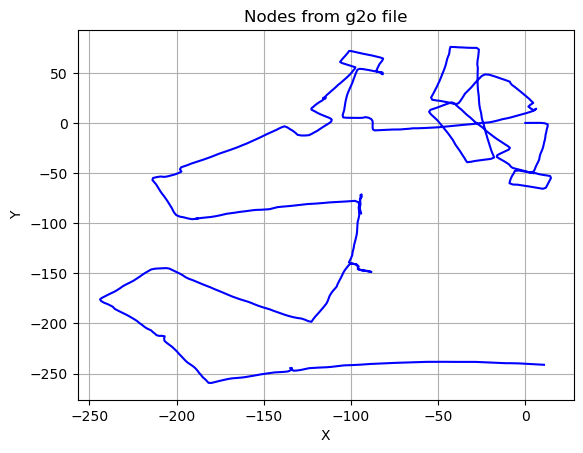

iter 1 with delta = 9776.815836743128
iter 2 with delta = 9921.583588625203
iter 3 with delta = 5304.764805540707
iter 4 with delta = 3618.3965580675276
iter 5 with delta = 933.9939988930216
iter 6 with delta = 659.25179621676
iter 7 with delta = 98.17909009324742
iter 8 with delta = 176.51470377625068
iter 9 with delta = 23.082354732268218
iter 10 with delta = 53.59284151969517
iter 11 with delta = 13.98510759884786
iter 12 with delta = 17.16245467982526
iter 13 with delta = 7.564224626983518
iter 14 with delta = 6.354698522871116
iter 15 with delta = 3.803701239394619
iter 16 with delta = 2.6231639339095367
iter 17 with delta = 1.8327618063756572
iter 18 with delta = 1.1540969135263155
iter 19 with delta = 0.8626333855900739
iter 20 with delta = 0.524695669824352
iter 21 with delta = 0.40107997682030955
iter 22 with delta = 0.2423091067959811
iter 23 with delta = 0.1853608923816005
iter 24 with delta = 0.11268047897148246
iter 25 with delta = 0.08543853115972769
iter 26 with delta = 

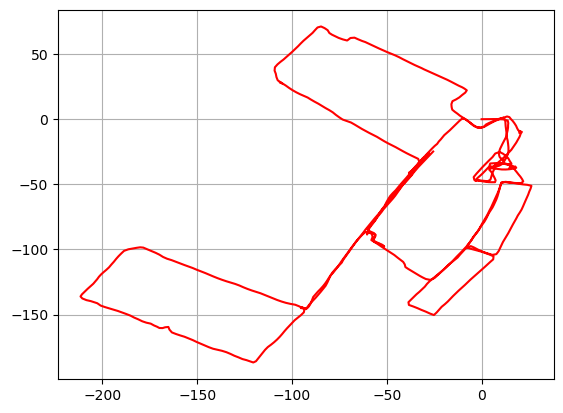

In [13]:
#  Imports and Configuration

import os
import matplotlib.pyplot as plt
import math
import numpy as np
import sys
from pathlib import Path


# Configuration
#np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.4f}'.format}, threshold=sys.maxsize)


def getNode(nodes, id):
    for node in nodes:

        if node["id"] == id:
            return node

# Cell 2: Helper Functions
def wrap2pi(theta):
    while theta > math.pi:
        theta = theta - 2 * math.pi
    while theta < -math.pi:
        theta = theta + 2 * math.pi
    return theta

def rot2(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], 
                     [np.sin(theta), np.cos(theta)]])

def update_node(node, dx):
    node["state"][0] += dx[0]
    node["state"][1] += dx[1]
    node["state"][2] = wrap2pi(node["state"][2] + dx[2])
    return node

# Cell 3: load_2d_g2o Function
def load_2d_g2o(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    nodes = []
    edges = []
    for line in lines:
        line = line.strip()
        if line.startswith('VERTEX_SE2'):
            parts = line.split()
            node = {
                'id': int(parts[1]),
                'state': [float(parts[2]), float(parts[3]), float(parts[4])]
            }
            nodes.append(node)
        elif line.startswith('EDGE_SE2'):
            parts = line.split()
            edge = {
                'id1': int(parts[1]),
                'id2': int(parts[2]),
                'meas': [float(parts[3]), float(parts[4]), float(parts[5])],
                'info': [[float(parts[6]), float(parts[7]), float(parts[8])],
                         [float(parts[7]), float(parts[9]), float(parts[10])],
                         [float(parts[8]), float(parts[10]), float(parts[11])]]
            }
            edges.append(edge)
    return nodes, edges

# Get project root - handle both script and notebook execution
try:
    # For scripts: use __file__
    script_dir = Path(__file__).resolve().parent
    project_root = script_dir.parent
except NameError:
    # For notebooks: find project root by searching for data/slam directory
    project_root = Path.cwd()
    for _ in range(5):  # Try up to 5 levels up
        data_test = project_root / "data" / "slam"
        if data_test.exists():
            break
        project_root = project_root.parent
data_dir = project_root / "data" / "slam"

# Default g2o file (can be overridden with command-line argument if needed)
# Available files: input_INTEL_g2o.g2o, input_M3500_g2o.g2o, input_MITb_g2o.g2o
g2o_file = data_dir / "input_MITb_g2o.g2o"

# Verify the file exists
if not g2o_file.exists():
    print(f"Error: G2O file not found at: {g2o_file}")
    print(f"Current directory: {Path.cwd()}")
    raise FileNotFoundError(f"G2O file not found: {g2o_file}")

# Load the g2o file
nodes, edges = load_2d_g2o(filename=str(g2o_file))

# Plot initial nodes
x_cords = [node["state"][0] for node in nodes]
y_cords = [node["state"][1] for node in nodes]
plt.plot(x_cords, y_cords, color="blue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nodes from g2o file')
plt.grid(True)
plt.show()

# Optimization loop
dx_norm = np.inf
iteration = 0

while dx_norm > 1e-2:
    # for i in [1]:
    # our matrices for Hx=-b
    b = np.zeros([3*len(x_cords), 1])
    H = np.zeros([3*len(x_cords), 3*len(x_cords)])

    for edge in edges:

        # idout
        id1 = edge["id1"]
        # idin
        id2 = edge["id2"]

        node1 = getNode(nodes, id1)
        node2 = getNode(nodes, id2)

        x1 = node1["state"][0]
        y1 = node1["state"][1]
        theta1 = node1["state"][2]

        x2 = node2["state"][0]
        y2 = node2["state"][1]
        theta2 = node2["state"][2]

        theta2_in_1 = wrap2pi(theta2-theta1)

        # orientation error
        err_theta = wrap2pi(wrap2pi(edge["meas"][2]) - theta2_in_1)

        # position error
        R_1toG = rot2(theta1)

        p_1inG = np.array([[x1], [y1]])
        p_2inG = np.array([[x2], [y2]])

        p_2in1 = R_1toG.T @ (p_2inG - p_1inG)

        p_2in1_from_measurement = np.array(
            [[edge["meas"][0]], [edge["meas"][1]]])

        err_pos_x, err_pos_y = p_2in1_from_measurement - p_2in1

        err_pos_x = err_pos_x.squeeze()
        err_pos_y = err_pos_y.squeeze()

        # 3x3d data on the file is I11 I12 I13 I22 I23 I33 but the matrix is symmetric so
        info = np.array(edge["info"])

        # Jacobian of current relative in respect to NODE 1

        A_i_j = np.array([[-np.cos(theta1), -np.sin(theta1), -np.sin(theta1)*(x2-x1) + np.cos(theta1)*(y2-y1)],
                          [np.sin(theta1), -np.cos(theta1), -np.cos(theta1) *
                           (x2-x1) - np.sin(theta1)*(y2-y1)],
                          [0, 0, -1]])

        # print("A_i_j:", A_i_j)

        # Jacobian of current relative in respect to NODE 2

        B_i_j = np.array([[np.cos(theta1), np.sin(theta1), 0],
                          [-np.sin(theta1), np.cos(theta1), 0], [0, 0, 1]])

        # print("B_i_j:", B_i_j)

        # update our information

        # H_i_i
        H[3*id1:3*id1+3, 3*id1:3*id1+3] = H[3*id1:3 *
                                            id1+3, 3*id1:3*id1+3] + A_i_j.T @ info@A_i_j

        # print("H_i_i:", H[3*id1:3*id1+3, 3*id1:3*id1+3])

        # H_i_j
        H[3*id1:3*id1+3, 3*id2:3*id2+3] = H[3*id1:3 *
                                            id1+3, 3*id2:3*id2+3] + A_i_j.T @ info @ B_i_j

        # print("H_i_j:", H[3*id1:3*id1+3, 3*id2:3*id2+3])

        # H_j_i
        H[3*id2:3*id2+3, 3*id1: 3*id1+3] = H[3*id2:3 *
                                             id2+3, 3*id1: 3*id1+3]+B_i_j.T@info@A_i_j

        # print("H_j_i:", H[3*id2:3*id2+3, 3*id1: 3*id1+3])

        # H_j_j
        H[3*id2:3*id2+3, 3*id2: 3*id2+3] = H[3*id2:3 *
                                             id2+3, 3*id2: 3*id2+3]+B_i_j.T@info@B_i_j

        # print("H_j_j:", H[3*id2:3*id2+3, 3*id2: 3*id2+3])

        # update our error terms
        result = A_i_j.T @ info @ np.array([[err_pos_x],
                                            [err_pos_y], [err_theta]])

        # print(result)
        # print("A_i_j:\n", A_i_j)

        result = result.squeeze()

        b[3*id1:3*id1+3, 0] = b[3*id1:3*id1+3, 0] + result

        # print("b1", b[3*id1:3*id1+3, 0])

        result = B_i_j.T @ info @ np.array([[err_pos_x],
                                           [err_pos_y], [err_theta]])

        # print("B_i_j:\n", B_i_j)

        result = result.squeeze()

 #       print(result)

        b[3*id2:3*id2+3, 0] = b[3*id2:3*id2+3, 0] + result

        # print("b2", b[3*id2:3*id2+3, 0])
        # print("err_pos_x,err_pos_y,err_theta", err_pos_x, err_pos_y, err_theta)


#  fix the first node to be known
    H[0:3, 0:3] = H[0:3, 0:3] + 1e6*np.eye(3)
    # solve the linear system
    # x = H\b
    x = np.linalg.solve(H, b)

    # print(x)
    # print(x.shape)

    dx_norm = np.linalg.norm(x)
    iteration = iteration + 1
    print(f'iter {iteration} with delta = {dx_norm}')

    # update our nodes
    for index, node in enumerate(nodes):
        node = update_node(node, x[3*index:3*index+3, 0])


x_cords = [node["state"][0] for node in nodes]
y_cords = [node["state"][1] for node in nodes]
theta = [node["state"][2] for node in nodes]

plt.plot(x_cords, y_cords, color="red")
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Nodes from g2o file')
plt.grid(True)
plt.show()